# Comparing Total Gas Masses Between Analyses - LoCuSS High-$L_{\rm{X}}$

This notebook measures gas masses for the LoCuSS High-$L_{\rm{X}}$ sample, then compares them to the measurements from literature. While the focus of this work is the measurement of total galaxy cluster masses, comparing measured gas masses gives us an avenue to probe how similar our measurements of the baryon density of the clusters are to those from literature. Seeing as knowledge of the gas density profile feeds into the total gas mass, its important to know if we are consistent.

## Import Statements

In [73]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError, Unit
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from typing import Union, List
from shutil import rmtree
import os
from tqdm import tqdm

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import locuss_colour, locuss_cosmo, direct_comparison_plot, find_lims, fit_comp

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 90
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.imagetools.psf import rl_psf
from xga.sourcetools.density import inv_abel_fitted_model, ann_spectra_apec_norm
from xga.models import BetaProfile1D, DoubleBetaProfile1D, KingProfile1D, DoubleKingProfile1D
from xga.exceptions import ModelNotAssociatedError
from xga.xspec import single_temp_apec
from xga.utils import r500 as r500_unit
from xga.products import BaseAggregateProfile1D

## Reading in literature data

### Gas masses from literature

In [9]:
loc_lit_gms = [locuss[locuss['name'] == n].iloc[0][['x_mg500', 'x_mg500_err', 'x_mg500_err']].values
               for n in locuss_srcs.names]
loc_lit_gm2500s = [locuss[locuss['name'] == n].iloc[0][['x_mg2500', 'x_mg2500_err', 'x_mg2500_err']].values
               for n in locuss_srcs.names]

# Turn the extracted values into a non-scalar astropy quantity
loc_lit_gms = Quantity(loc_lit_gms, 'Msun')
loc_lit_gm2500s = Quantity(loc_lit_gm2500s, 'Msun')

### Conversion Temperatures

In [18]:
loc_conv_txs = []
    
for src in locuss_srcs:
    rel_row = locuss[locuss['name'] == src.name].iloc[0]
    if not np.isnan(rel_row['x_Tx500ce']):
        loc_conv_txs.append(rel_row['x_Tx500ce'])
    else:
        loc_conv_txs.append(src.get_temperature(src.r500, inner_radius=src.r500*0.15).value[0])

loc_conv_txs = Quantity(loc_conv_txs, 'keV')
loc_conv_txs

<Quantity [ 6.992  ,  7.658  ,  6.322  ,  5.848  ,  5.71599,  3.45714,
            7.038  ,  5.90133,  4.033  ,  4.574  ,  6.718  ,  6.11918,
            6.32049,  9.58744,  4.068  ,  5.47196,  7.525  ,  6.631  ,
            2.797  ,  6.64412,  6.527  ,  7.113  ,  8.868  ,  4.72697,
            9.182  ,  7.198  ,  6.725  ,  8.498  ,  8.105  ,  4.907  ,
            6.14395,  6.405  ,  7.415  ,  7.60175,  8.478  , 10.133  ,
            7.446  ,  7.49377,  5.317  ,  5.783  , 10.787  ,  7.023  ,
            7.5224 ,  6.912  ,  6.65512] keV>

## Reading in Sample File and Declaring XGA ClusterSample

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

### LoCuSS High-$L_{\rm{X}}$

The LoCuSS High-$L_{\rm{X}}$ sample was selected from ROSAT for its high luminosity clusters, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [2]:
locuss = pd.read_csv("../../sample_files/locuss_highlx_clusters.csv", dtype={'chandra_id': str, 'xmm_obsid': str})

In [3]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = locuss['ra'].values
dec = locuss['dec'].values
z = locuss['z'].values
n = locuss['name'].values
r500 = Quantity(locuss['r500'].values, 'kpc')
r2500 = Quantity(locuss['r2500'].values, 'kpc')

# Declaring the actual ClusterSample instance for the LoCuSS sample
locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True, 
                            use_peak=False, clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Setting up Galaxy Clusters: 100%|█████████████████████████████████████████████| 45/45 [01:12<00:00,  1.61s/it]
/tmp/ipykernel_54387/1394207490.py:10: UserWarning: The following do not appear to have any XMM data, and will not be included in the sample (can also check .failed_names); ZwCl0949.6+5207, Abell1423, RXCJ1212.3-1816, Abell1682, Abell2485
  locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True,
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:237: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()


## Running PSF Correction

In [4]:
rl_psf(locuss_srcs, bins=10)

Generating products of type(s) image: 100%|███████████████████████████████████| 45/45 [00:06<00:00,  7.13it/s]


## Gas Density Profile Generation and Comparison to Literature - from $S_{B}$ Profiles

### Beta and King Profiles - out to $R_{500}$

In [ ]:
# demo_sb_mod = BetaProfile1D()
# demo_sb_mod.info()
# demo_sb_mod.par_priors

In [81]:
loc_beta_1r500_dp = inv_abel_fitted_model(locuss_srcs, 'beta', 'mcmc', locuss_srcs.r500, 
                                          conv_temp=loc_conv_txs, psf_bins=10)

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 45/45 [27:59<00:00, 37.33s/it]


In [83]:
loc_beta_king_1r500_gm500 = []
loc_beta_king_1r500_gm2500 = []
with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_beta_1r500_dp)) as onwards:
    for dp in loc_dblbeta_1r500_dp:
        if dp is not None:
            dp.fit('king')
            gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
            loc_beta_king_1r500_gm500.append(gm)
            gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r2500)[0]
            loc_beta_king_1r500_gm2500.append(gm)
        else:
            loc_beta_king_1r500_gm500.append([np.NaN, np.NaN, np.NaN])
            loc_beta_king_1r500_gm2500.append([np.NaN, np.NaN, np.NaN])
            
        onwards.update(1)        

loc_beta_king_1r500_gm500 = Quantity(loc_beta_king_1r500_gm500, 'Msun')
loc_beta_king_1r500_gm2500 = Quantity(loc_beta_king_1r500_gm2500, 'Msun')

 27%|██████████████████▍                                                | 8243/30000 [00:14<00:36, 589.25it/s]


 56%|█████████████████████████████████████▏                            | 16877/30000 [00:29<00:22, 588.85it/s]


 86%|████████████████████████████████████████████████████████▍         | 25675/30000 [00:43<00:07, 591.45it/s]


100%|██████████████████████████████████████████████████████████████████| 30000/30000 [00:51<00:00, 584.66it/s]
/tmp/ipykernel_54387/3582148429.py:7: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]


 28%|██████████████████▌                                                | 8320/30000 [00:14<00:33, 642.73it/s]


 57%|█████████████████████████████████████▌                            | 17088/30000 [00:29<00:22, 581.48it/s]


 85%|████████████████████████████████████████████████████████          | 25489/30000 [00:43<00:07, 635.36it/s]


 14%|█████████▎                                                         | 4164/30000 [00:06<00:41, 615.94it/s]


 43%|████████████████████████████▋                                     | 13030/30000 [00:21<00:27, 614.88it/s]


 74%|████████████████████████████████████████████████▉                 | 22262/30000 [00:36<00:12, 608.04it/s]


  5%|███▎                                                               | 1498/30000 [00:02<00:45, 625.27it/s]


 36%|███████████████████████▌                                          | 10731/30000 [00:17<00:29, 655.43it/s]


 66%|███████████████████████████████████████████▌                      | 19797/30000 [00:31<00:17, 572.63it/s]


 96%|███████████████████████████████████████████████████████████████▏  | 28738/30000 [00:46<00:02, 560.08it/s]


100%|██████████████████████████████████████████████████████████████████| 30000/30000 [00:48<00:00, 618.85it/s]
/tmp/ipykernel_54387/3582148429.py:7: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
 25%|████████████████▍                                                  | 7385/30000 [00:12<00:37, 604.30it/s]


 54%|███████████████████████████████████▊                              | 16261/30000 [00:27<00:23, 592.17it/s]


 84%|███████████████████████████████████████████████████████▋          | 25321/30000 [00:41<00:07, 668.32it/s]


100%|██████████████████████████████████████████████████████████████████| 30000/30000 [00:49<00:00, 608.86it/s]
/tmp/ipykernel_54387/3582148429.py:7: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
 14%|█████████▌                                                         | 4273/30000 [00:06<00:37, 678.25it/s]


 46%|██████████████████████████████                                    | 13679/30000 [00:21<00:25, 636.00it/s]


 77%|██████████████████████████████████████████████████▌               | 23009/30000 [00:36<00:10, 695.94it/s]


  7%|████▋                                                              | 2089/30000 [00:03<00:56, 492.20it/s]


 36%|███████████████████████▌                                          | 10715/30000 [00:18<00:30, 635.43it/s]


 65%|██████████████████████████████████████████▋                       | 19409/30000 [00:32<00:17, 597.21it/s]


 94%|█████████████████████████████████████████████████████████████▊    | 28092/30000 [00:47<00:03, 623.86it/s]


 23%|███████████████▎                                                   | 6839/30000 [00:11<00:37, 613.51it/s]


 52%|██████████████████████████████████▌                               | 15702/30000 [00:25<00:23, 596.64it/s]


 81%|█████████████████████████████████████████████████████▍            | 24269/30000 [00:40<00:10, 554.43it/s]


 10%|██████▊                                                            | 3034/30000 [00:05<00:44, 605.31it/s]


 40%|██████████████████████████                                        | 11862/30000 [00:19<00:29, 615.24it/s]


 70%|██████████████████████████████████████████████                    | 20925/30000 [00:34<00:13, 652.41it/s]


100%|██████████████████████████████████████████████████████████████████| 30000/30000 [00:49<00:00, 611.14it/s]
/tmp/ipykernel_54387/3582148429.py:7: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]


 27%|██████████████████                                                 | 8082/30000 [00:14<00:37, 590.22it/s]


 54%|███████████████████████████████████▉                              | 16340/30000 [00:29<00:23, 590.56it/s]


 83%|██████████████████████████████████████████████████████▌           | 24803/30000 [00:44<00:07, 698.95it/s]


100%|██████████████████████████████████████████████████████████████████| 30000/30000 [00:53<00:00, 565.33it/s]
/tmp/ipykernel_54387/3582148429.py:7: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
 11%|███████▋                                                           | 3424/30000 [00:05<00:42, 628.42it/s]


 40%|██████████████████████████▎                                       | 11955/30000 [00:20<00:27, 660.62it/s]


 69%|█████████████████████████████████████████████▊                    | 20807/30000 [00:35<00:16, 570.70it/s]


 99%|█████████████████████████████████████████████████████████████████▍| 29744/30000 [00:50<00:00, 548.21it/s]


100%|██████████████████████████████████████████████████████████████████| 30000/30000 [00:50<00:00, 591.31it/s]
/tmp/ipykernel_54387/3582148429.py:7: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
 26%|█████████████████▌                                                 | 7873/30000 [00:14<00:37, 596.31it/s]


 54%|███████████████████████████████████▋                              | 16229/30000 [00:28<00:23, 574.48it/s]


 82%|██████████████████████████████████████████████████████▏           | 24653/30000 [00:43<00:09, 552.17it/s]


 12%|███████▉                                                           | 3539/30000 [00:05<00:43, 608.08it/s]


 42%|███████████████████████████▋                                      | 12600/30000 [00:20<00:29, 590.01it/s]


 72%|███████████████████████████████████████████████▌                  | 21612/30000 [00:34<00:13, 620.39it/s]


100%|██████████████████████████████████████████████████████████████████| 30000/30000 [00:49<00:00, 611.94it/s]
/tmp/ipykernel_54387/3582148429.py:7: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
  1%|▍                                                                   | 188/30000 [00:00<00:50, 595.68it/s]


 30%|███████████████████▉                                               | 8948/30000 [00:14<00:35, 593.20it/s]


 58%|██████████████████████████████████████▌                           | 17512/30000 [00:29<00:20, 617.23it/s]


 87%|█████████████████████████████████████████████████████████▏        | 26007/30000 [00:44<00:06, 585.15it/s]


100%|██████████████████████████████████████████████████████████████████| 30000/30000 [00:51<00:00, 587.47it/s]
/tmp/ipykernel_54387/3582148429.py:7: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
 16%|██████████▊                                                        | 4831/30000 [00:07<00:40, 628.89it/s]


 47%|███████████████████████████████▏                                  | 14185/30000 [00:22<00:25, 631.50it/s]


 77%|███████████████████████████████████████████████████               | 23221/30000 [00:37<00:12, 563.15it/s]


  7%|████▌                                                              | 2054/30000 [00:03<00:47, 582.24it/s]


 35%|███████████████████████▎                                          | 10594/30000 [00:18<00:34, 568.01it/s]


 64%|██████████████████████████████████████████▌                       | 19336/30000 [00:32<00:18, 567.56it/s]


 93%|█████████████████████████████████████████████████████████████▍    | 27921/30000 [00:47<00:03, 594.19it/s]


100%|██████████████████████████████████████████████████████████████████| 30000/30000 [00:50<00:00, 590.23it/s]
/tmp/ipykernel_54387/3582148429.py:7: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
 22%|██████████████▉                                                    | 6667/30000 [00:10<00:37, 624.21it/s]


 52%|██████████████████████████████████▏                               | 15519/30000 [00:25<00:23, 624.06it/s]


 82%|█████████████████████████████████████████████████████▉            | 24527/30000 [00:39<00:09, 595.84it/s]


 11%|███████▋                                                           | 3440/30000 [00:05<00:43, 614.62it/s]


 42%|███████████████████████████▌                                      | 12550/30000 [00:19<00:29, 597.44it/s]


 73%|████████████████████████████████████████████████▏                 | 21914/30000 [00:34<00:11, 679.41it/s]


100%|██████████████████████████████████████████████████████████████████| 30000/30000 [00:47<00:00, 633.80it/s]
/tmp/ipykernel_54387/3582148429.py:7: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
  3%|█▉                                                                  | 848/30000 [00:01<00:48, 606.04it/s]


 33%|█████████████████████▊                                             | 9772/30000 [00:16<00:35, 573.38it/s]


 60%|███████████████████████████████████████▎                          | 17888/30000 [00:31<00:21, 564.72it/s]


 87%|█████████████████████████████████████████████████████████▎        | 26045/30000 [00:45<00:06, 574.69it/s]


100%|██████████████████████████████████████████████████████████████████| 30000/30000 [00:52<00:00, 567.66it/s]
/tmp/ipykernel_54387/3582148429.py:7: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
 14%|█████████▌                                                         | 4297/30000 [00:07<00:48, 530.28it/s]


 43%|████████████████████████████▎                                     | 12862/30000 [00:22<00:28, 609.92it/s]


 73%|████████████████████████████████████████████████                  | 21839/30000 [00:37<00:14, 573.01it/s]


100%|██████████████████████████████████████████████████████████████████| 30000/30000 [00:50<00:00, 589.16it/s]
/tmp/ipykernel_54387/3582148429.py:7: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
  1%|▊                                                                   | 365/30000 [00:00<00:49, 597.52it/s]


 31%|█████████████████████                                              | 9422/30000 [00:15<00:36, 563.21it/s]


 60%|███████████████████████████████████████▊                          | 18090/30000 [00:30<00:19, 601.69it/s]


 91%|███████████████████████████████████████████████████████████▊      | 27180/30000 [00:44<00:04, 593.26it/s]


 19%|████████████▊                                                      | 5735/30000 [00:10<00:55, 433.85it/s]


 46%|██████████████████████████████▎                                   | 13769/30000 [00:25<00:29, 548.67it/s]


 73%|████████████████████████████████████████████████▍                 | 22004/30000 [00:39<00:14, 545.49it/s]


  1%|▉                                                                   | 421/30000 [00:00<00:51, 578.46it/s]


 30%|████████████████████▍                                              | 9126/30000 [00:15<00:35, 580.60it/s]


 59%|██████████████████████████████████████▋                           | 17601/30000 [00:30<00:22, 550.63it/s]


 87%|█████████████████████████████████████████████████████████▍        | 26114/30000 [00:45<00:06, 597.33it/s]


 15%|██████████▎                                                        | 4631/30000 [00:08<00:48, 520.66it/s]


 43%|████████████████████████████▌                                     | 12967/30000 [00:22<00:29, 580.04it/s]


 72%|███████████████████████████████████████████████▍                  | 21552/30000 [00:37<00:14, 567.02it/s]


100%|██████████████████████████████████████████████████████████████████| 30000/30000 [00:51<00:00, 577.80it/s]
/tmp/ipykernel_54387/3582148429.py:7: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]


 28%|███████████████████                                                | 8537/30000 [00:14<00:35, 599.78it/s]


 58%|██████████████████████████████████████▏                           | 17367/30000 [00:29<00:22, 569.75it/s]


 87%|█████████████████████████████████████████████████████████▏        | 26013/30000 [00:43<00:06, 573.37it/s]


100%|██████████████████████████████████████████████████████████████████| 30000/30000 [00:50<00:00, 592.71it/s]
/tmp/ipykernel_54387/3582148429.py:7: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
 15%|█████████▉                                                         | 4457/30000 [00:07<00:42, 594.26it/s]


 44%|█████████████████████████████▏                                    | 13263/30000 [00:22<00:28, 585.21it/s]


 74%|████████████████████████████████████████████████▉                 | 22246/30000 [00:37<00:13, 594.98it/s]


100%|██████████████████████████████████████████████████████████████████| 30000/30000 [00:50<00:00, 597.57it/s]
/tmp/ipykernel_54387/3582148429.py:7: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
  2%|█▌                                                                  | 664/30000 [00:01<00:52, 562.84it/s]


 31%|████████████████████▋                                              | 9291/30000 [00:15<00:38, 542.49it/s]


 60%|███████████████████████████████████████▋                          | 18067/30000 [00:30<00:20, 594.91it/s]


 88%|██████████████████████████████████████████████████████████▎       | 26509/30000 [00:45<00:05, 595.37it/s]


 14%|█████████▍                                                         | 4248/30000 [00:08<00:50, 514.38it/s]


 41%|███████████████████████████▎                                      | 12401/30000 [00:23<00:35, 495.19it/s]


 67%|████████████████████████████████████████████▍                     | 20215/30000 [00:38<00:16, 600.93it/s]


 93%|█████████████████████████████████████████████████████████████▋    | 28018/30000 [00:53<00:04, 486.97it/s]


100%|██████████████████████████████████████████████████████████████████| 30000/30000 [00:57<00:00, 522.94it/s]
/tmp/ipykernel_54387/3582148429.py:7: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
 20%|█████████████▎                                                     | 5943/30000 [00:10<00:39, 615.99it/s]


 50%|█████████████████████████████████▎                                | 15129/30000 [00:25<00:24, 615.78it/s]


 81%|█████████████████████████████████████████████████████▍            | 24317/30000 [00:39<00:08, 636.37it/s]


100%|██████████████████████████████████████████████████████████████████| 30000/30000 [00:48<00:00, 616.52it/s]
/tmp/ipykernel_54387/3582148429.py:7: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
 10%|██████▊                                                            | 3028/30000 [00:05<00:50, 532.18it/s]


 37%|████████████████████████▌                                         | 11142/30000 [00:20<00:39, 482.80it/s]


 66%|███████████████████████████████████████████▎                      | 19665/30000 [00:35<00:16, 623.67it/s]


 93%|█████████████████████████████████████████████████████████████▍    | 27915/30000 [00:49<00:03, 553.35it/s]


100%|██████████████████████████████████████████████████████████████████| 30000/30000 [00:53<00:00, 556.63it/s]
/tmp/ipykernel_54387/3582148429.py:7: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
 22%|██████████████▊                                                    | 6606/30000 [00:10<00:39, 597.38it/s]


 52%|██████████████████████████████████▎                               | 15620/30000 [00:25<00:22, 647.46it/s]


 84%|███████████████████████████████████████████████████████           | 25050/30000 [00:40<00:07, 675.05it/s]


 13%|████████▊                                                          | 3919/30000 [00:06<00:45, 577.62it/s]


 41%|███████████████████████████▏                                      | 12367/30000 [00:21<00:32, 547.47it/s]


 69%|█████████████████████████████████████████████▊                    | 20808/30000 [00:36<00:15, 603.12it/s]


 97%|████████████████████████████████████████████████████████████████▏ | 29178/30000 [00:50<00:01, 604.01it/s]


100%|██████████████████████████████████████████████████████████████████| 30000/30000 [00:52<00:00, 575.61it/s]
/tmp/ipykernel_54387/3582148429.py:7: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
 26%|█████████████████▌                                                 | 7864/30000 [00:12<00:36, 605.95it/s]


 55%|████████████████████████████████████▍                             | 16579/30000 [00:27<00:22, 608.27it/s]


 87%|█████████████████████████████████████████████████████████▎        | 26042/30000 [00:42<00:06, 601.31it/s]


 16%|██████████▉                                                        | 4918/30000 [00:08<00:47, 529.93it/s]


 44%|█████████████████████████████▎                                    | 13303/30000 [00:23<00:26, 635.97it/s]


 72%|███████████████████████████████████████████████▊                  | 21739/30000 [00:38<00:14, 579.25it/s]


100%|██████████████████████████████████████████████████████████████████| 30000/30000 [00:51<00:00, 582.12it/s]
/tmp/ipykernel_54387/3582148429.py:7: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
  2%|█▌                                                                  | 677/30000 [00:01<00:40, 727.53it/s]


 39%|█████████████████████████▋                                        | 11691/30000 [00:15<00:23, 783.72it/s]


 73%|███████████████████████████████████████████████▉                  | 21804/30000 [00:30<00:15, 540.92it/s]


  9%|█████▊                                                             | 2624/30000 [00:03<00:33, 820.87it/s]


 49%|████████████████████████████████                                  | 14553/30000 [00:17<00:18, 857.65it/s]


 90%|███████████████████████████████████████████████████████████▏      | 26897/30000 [00:31<00:03, 866.61it/s]


 32%|█████████████████████                                              | 9454/30000 [00:10<00:22, 901.67it/s]


 75%|█████████████████████████████████████████████████▎                | 22411/30000 [00:24<00:08, 911.19it/s]


100%|██████████████████████████████████████████████████████████████████| 30000/30000 [00:33<00:00, 902.89it/s]
/tmp/ipykernel_54387/3582148429.py:7: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
 17%|███████████▌                                                       | 5173/30000 [00:05<00:26, 919.55it/s]


 61%|████████████████████████████████████████▎                         | 18326/30000 [00:19<00:12, 920.81it/s]


  5%|███▏                                                               | 1400/30000 [00:01<00:30, 929.20it/s]


 49%|████████████████████████████████▏                                 | 14631/30000 [00:15<00:16, 921.36it/s]


 92%|████████████████████████████████████████████████████████████▉     | 27710/30000 [00:30<00:02, 916.68it/s]


 34%|██████████████████████▍                                           | 10187/30000 [00:11<00:22, 878.60it/s]


 76%|██████████████████████████████████████████████████                | 22777/30000 [00:25<00:08, 881.17it/s]


100%|██████████████████████████████████████████████████████████████████| 30000/30000 [00:34<00:00, 877.38it/s]
/tmp/ipykernel_54387/3582148429.py:7: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
 18%|████████████                                                       | 5388/30000 [00:05<00:26, 936.56it/s]


 62%|█████████████████████████████████████████▏                        | 18739/30000 [00:20<00:12, 936.73it/s]


  7%|████▍                                                              | 1971/30000 [00:02<00:30, 933.41it/s]


 51%|█████████████████████████████████▋                                | 15315/30000 [00:16<00:15, 934.59it/s]


 96%|███████████████████████████████████████████████████████████████   | 28653/30000 [00:30<00:01, 933.59it/s]


100%|██████████████████████████████████████████████████████████████████| 30000/30000 [00:32<00:00, 932.18it/s]
/tmp/ipykernel_54387/3582148429.py:7: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
 38%|█████████████████████████▍                                        | 11546/30000 [00:12<00:19, 932.67it/s]


 83%|██████████████████████████████████████████████████████▋           | 24859/30000 [00:26<00:05, 933.15it/s]


100%|██████████████████████████████████████████████████████████████████| 30000/30000 [00:32<00:00, 928.34it/s]
/tmp/ipykernel_54387/3582148429.py:7: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
 26%|█████████████████▌                                                 | 7879/30000 [00:08<00:23, 933.26it/s]


 71%|██████████████████████████████████████████████▋                   | 21205/30000 [00:22<00:09, 934.96it/s]


Calculating LoCuSS gas masses: 100%|██████████████████████████████████████████| 45/45 [36:53<00:00, 49.19s/it]


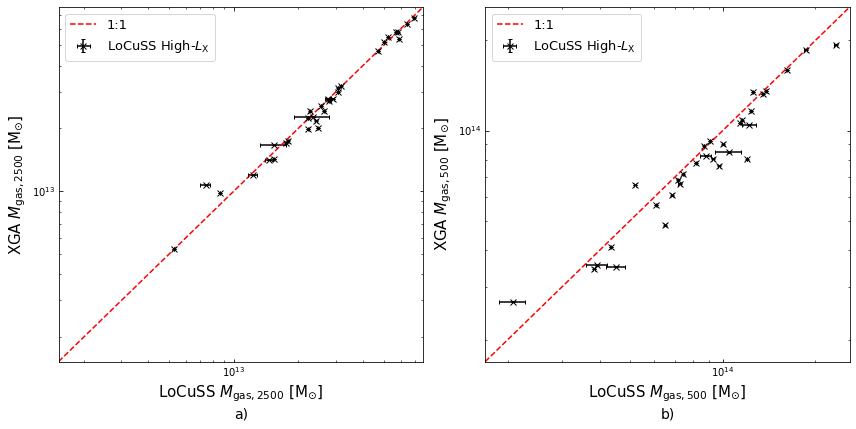

In [84]:
direct_comparison_plot([loc_lit_gm2500s, loc_lit_gms], 
                       [loc_beta_king_1r500_gm2500, loc_beta_king_1r500_gm500], 
                       [r"LoCuSS $M_{\rm{gas, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{gas, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{gas, 2500}}$ [M$_{\odot}$]", r"XGA $M_{\rm{gas, 500}}$ [M$_{\odot}$]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6), ['log', 'log'], ['log', 'log'], 
                       savepath='../../outputs/figures/locuss_1r500_gmcomp_beta_king.pdf')

In [ ]:
# demo_d_mod = KingProfile1D(y_unit=Unit("1 / cm^3"))
# demo_d_mod.info()
# demo_d_mod.par_priors

In [ ]:
# with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_beta_1r500_dp)) as onwards:
#     for dp in loc_beta_1r500_dp:
#         if dp is not None:
#             dp.fit('king', progress_bar=False)
#         onwards.update(1)

In [ ]:
# loc_beta_king_1r500_gm500 = []
# loc_beta_king_1r500_gm2500 = []

# with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_beta_1r500_dp)) as onwards:
#     for dp in loc_beta_1r500_dp:
#         if dp is not None:
#             gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
#             loc_beta_king_1r500_gm500.append(gm)
#             gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r2500)[0]
#             loc_beta_king_1r500_gm2500.append(gm)
#         else:
#             loc_beta_king_1r500_gm2500.append([np.NaN, np.NaN, np.NaN])
#             loc_beta_king_1r500_gm500.append([np.NaN, np.NaN, np.NaN])
#         onwards.update(1)               
        
# loc_beta_king_1r500_gm500 = Quantity(loc_beta_king_1r500_gm500, 'Msun')
# loc_beta_king_1r500_gm2500 = Quantity(loc_beta_king_1r500_gm2500, 'Msun')

In [ ]:
# direct_comparison_plot([loc_lit_gm2500s, loc_lit_gms], [loc_beta_king_1r500_gm2500, loc_beta_king_1r500_gm500], 
#                        [r"LoCuSS $M_{\rm{gas, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{gas, 500}}$ [M$_{\odot}$]"], 
#                        [r"XGA $M_{\rm{gas, 2500}}$ [keV]", r"XGA $M_{\rm{gas, 500}}$ [keV]"],
#                        r"LoCuSS High-$L_{\rm{X}}$", (12, 6), ['log', 'log'], ['log', 'log'])
# # savepath='../../outputs/figures/locussBLAH_comp.pdf'

### Double Beta and Double King Profiles - out to $R_{500}$

In [6]:
demo_sb_mod = DoubleBetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═══════════════════════╤════════════════════════════════════════════════════════════════════════════╕
│ Double Beta Profile   │                                                                            │
╞═══════════════════════╪════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES             │ Surface Brightness                                                         │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ UNIT                  │ ct / (arcmin2 s)                                                           │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS            │ beta_one, r_core_one, norm_one, beta_two, r_core_two, norm_two             │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS       │ , kpc, ct / (arcmin2 s), , kpc, ct / (arcmin2 s

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [19]:
loc_dblbeta_1r500_dp = inv_abel_fitted_model(locuss_srcs, 'double_beta', 'mcmc', locuss_srcs.r500, 
                                             conv_temp=loc_conv_txs, psf_bins=10, )

Running XSPEC Simulations: 100%|██████████████████████████████████████████████| 45/45 [00:23<00:00,  1.92it/s]
Fitting data, inverse Abel transforming, and measuring densities:   2%|▏       | 1/45 [00:25<18:33, 25.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 900.31749665  761.77870122 1071.08255681  965.94641595 1058.26542852
  986.18706649]


Fitting data, inverse Abel transforming, and measuring densities:   4%|▎       | 2/45 [00:51<18:30, 25.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 540.45595312  474.0388766   977.67055519  918.11083889  957.40477116
 1005.24172452]


Fitting data, inverse Abel transforming, and measuring densities:   7%|▌       | 3/45 [01:15<17:21, 24.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1704.33849558 1239.78851937 1899.826134   1684.54982617 1868.14853902
 1932.556785  ]


Fitting data, inverse Abel transforming, and measuring densities:   9%|▋       | 4/45 [01:37<16:22, 23.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 926.18724542 1956.26298741 1571.76801387 1910.2278041  1688.61302967
 2032.39806898]


Fitting data, inverse Abel transforming, and measuring densities:  18%|█▍      | 8/45 [03:18<15:24, 24.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 235.73083695  308.15672132 1377.95663089 1222.57046011 1310.88863871
 1282.94979518]


Fitting data, inverse Abel transforming, and measuring densities:  24%|█▋     | 11/45 [04:34<14:07, 24.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [197.54694799 363.22969185 510.06529663 162.31031244 168.87176174
 155.10878896]


Fitting data, inverse Abel transforming, and measuring densities:  27%|█▊     | 12/45 [05:02<14:14, 25.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 989.14700113 1019.37970095 1036.32199032  904.7049713   960.50140244
 1013.37257453]


Fitting data, inverse Abel transforming, and measuring densities:  29%|██     | 13/45 [05:27<13:45, 25.79s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1383.64919141  241.83643178 1206.38072871 1296.33974741 1477.76283719
 1231.59611351]


Fitting data, inverse Abel transforming, and measuring densities:  31%|██▏    | 14/45 [05:53<13:17, 25.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1755.14078986  642.02659243 1902.2305439  1753.08731942 1875.30463979
 1773.86978801]


Fitting data, inverse Abel transforming, and measuring densities:  36%|██▍    | 16/45 [06:43<12:10, 25.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 971.73705768 1544.64442249 1630.58999871 1600.92771506 1681.01307208
 1719.89745737]


Fitting data, inverse Abel transforming, and measuring densities:  38%|██▋    | 17/45 [07:09<11:53, 25.48s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 549.91080142  663.35880762 1671.92344465 1165.37798492 1188.32096748
 1294.5768775 ]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:614: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of Abell0781's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  40%|██▊    | 18/45 [07:32<11:11, 24.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 786.46600618  714.01606833 1774.10392157 2418.53336242 2406.54298927
 1614.53990414]


Fitting data, inverse Abel transforming, and measuring densities:  44%|███    | 20/45 [08:26<10:50, 26.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1005.82379604 1046.69401546 1200.55962103 1156.50277303 1231.35464952
 1227.90417867]


Fitting data, inverse Abel transforming, and measuring densities:  49%|███▍   | 22/45 [09:23<10:25, 27.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 539.80459422  301.28790381 1611.36564037 1264.7010306  1021.30192812
 1491.35584666]


Fitting data, inverse Abel transforming, and measuring densities:  53%|███▋   | 24/45 [10:11<08:58, 25.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 946.65948811  452.09304207 2131.41396205  682.85329324  765.21620557
 2122.87449226]


Fitting data, inverse Abel transforming, and measuring densities:  58%|████   | 26/45 [11:03<08:05, 25.57s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1101.77012011  502.39919823 1731.9761381   817.16791467  948.01352491
 1735.70253827]


Fitting data, inverse Abel transforming, and measuring densities:  60%|████▏  | 27/45 [11:29<07:41, 25.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 795.48251722 1018.39054307 1756.45687241 1527.39278163 1424.98014434
 1466.91679342]


Fitting data, inverse Abel transforming, and measuring densities:  71%|████▉  | 32/45 [13:40<05:33, 25.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 570.55517774  897.50464464 1922.61978336  961.72020635 1084.04297097
 1908.40670344]


Fitting data, inverse Abel transforming, and measuring densities:  76%|█████▎ | 34/45 [14:32<04:42, 25.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 807.08523393  545.80856841  949.04027444  912.83664388  957.97105995
 1011.82097838]


Fitting data, inverse Abel transforming, and measuring densities:  78%|█████▍ | 35/45 [15:00<04:25, 26.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [408.36826579 401.8845743  443.45091714 273.87109497 323.63345988
 450.86079257]


Fitting data, inverse Abel transforming, and measuring densities:  93%|██████▌| 42/45 [18:08<01:18, 26.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1571.66083102  881.87903337 1735.49291557 1304.10832097 1408.08623702
 1721.79006315]


Fitting data, inverse Abel transforming, and measuring densities:  96%|██████▋| 43/45 [18:34<00:52, 26.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [255.11498966 445.30720978 360.06024365 316.13873385 384.37575874
 472.8965858 ]


Fitting data, inverse Abel transforming, and measuring densities:  98%|██████▊| 44/45 [18:58<00:25, 25.53s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 903.6733032  1029.70263382 1275.35687833 1199.63663642 1249.97697481
 1268.59242163]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 45/45 [19:22<00:00, 25.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 719.6246743   323.30943537 1713.63028706 1203.58402608  511.95328589
 1673.74711203]


In [20]:
demo_d_mod = DoubleKingProfile1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒═══════════════════════╤════════════════════════════════════════════════════════════════╕
│ Double King Profile   │                                                                │
╞═══════════════════════╪════════════════════════════════════════════════════════════════╡
│ DESCRIBES             │ Gas Density                                                    │
├───────────────────────┼────────────────────────────────────────────────────────────────┤
│ UNIT                  │ 1 / cm3                                                        │
├───────────────────────┼────────────────────────────────────────────────────────────────┤
│ PARAMETERS            │ beta_one, r_core_one, norm_one, beta_two, r_core_two, norm_two │
├───────────────────────┼────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS       │ , kpc, 1 / cm3, , kpc, 1 / cm3                                 │
├───────────────────────┼────────────────────────────────────────────────────────────────┤

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [21]:
with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_dblbeta_1r500_dp)) as onwards:
    for dp in loc_dblbeta_1r500_dp:
        if dp is not None:
            dp.fit('double_king', progress_bar=False)
        onwards.update(1)

Fitting density model to LoCuSS profiles:   2%|▋                               | 1/45 [00:39<29:06, 39.70s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [776.85159277 805.71569559 824.68462166 464.15117917 622.38028843
 787.82867649]


Fitting density model to LoCuSS profiles:   4%|█▍                              | 2/45 [01:18<28:13, 39.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1122.74628088 1150.52697559 1313.86141489  567.56479116  928.97482478
 1263.38855916]


Fitting density model to LoCuSS profiles:   7%|██▏                             | 3/45 [01:57<27:25, 39.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2459.47546028 2471.53840516 2502.21458126 2200.72186983 2345.67403225
 2494.83273683]


Fitting density model to LoCuSS profiles:   9%|██▊                             | 4/45 [02:33<25:44, 37.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2717.38951819 2421.32676816 3084.66907725 2541.51881513 2692.5538149
 3075.33144415]


Fitting density model to LoCuSS profiles:  18%|█████▋                          | 8/45 [04:59<22:34, 36.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2956.66242908 2875.27339391 1756.21361961 2851.58167786 2933.1709085
 1399.1524792 ]


Fitting density model to LoCuSS profiles:  24%|███████▌                       | 11/45 [06:50<20:31, 36.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 218.28130865  221.65842543  223.91316579  361.66161578 1718.98069286
 1477.20478639]


Fitting density model to LoCuSS profiles:  29%|████████▉                      | 13/45 [08:05<19:31, 36.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2028.04346273 1934.93868828 1794.3101162  2729.56670617 2699.89484654
 2361.74519405]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/density.py:219: RuntimeWarning: overflow encountered in power
  (norm_two * ((1 + (x / r_core_two)**2)**(-3 * beta_two)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/fitting.py:27: RuntimeWarning: overflow encountered in square
  lik = -np.sum(np.log(y_err*np.sqrt(2*np.pi)) + (((y - m_func(r, *theta))**2) / (2*y_err**2)))
/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/density.py:219: RuntimeWarning: overflow encountered in power
  (norm_two * ((1 + (x / r_core_two)**2)**(-3 * beta_two)))
/mnt/pact/dt237/code/Pycharm

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1532.93670244 1863.4143661   973.35488026 2028.99731952 2219.96819028
 2065.76839966]


Fitting density model to LoCuSS profiles:  33%|██████████▎                    | 15/45 [09:09<17:06, 34.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2190.54883614 1670.85989067  902.99054399 2241.09048325 2053.03418455
  848.20300922]


Fitting density model to LoCuSS profiles:  36%|███████████                    | 16/45 [09:49<17:18, 35.80s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [3004.12848154 2371.70020097 2724.91437462 2413.31303348 2331.2740635
 2663.63983578]


Fitting density model to LoCuSS profiles:  38%|███████████▋                   | 17/45 [10:24<16:41, 35.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2185.47740242 2424.07362509 1765.47494637 2140.97835864 2450.68659754
 2037.30736733]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"
Fitting density model to LoCuSS profiles:  42%|█████████████                  | 19/45 [11:02<12:03, 27.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 500.56302233  200.1048084  1395.84202976  589.83063704 1171.20620079
  953.52844493]


Fitting density model to LoCuSS profiles:  51%|███████████████▊               | 23/45 [13:42<13:19, 36.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1328.49575629 1484.17906283 1812.52327083 1770.90504147 1785.32648806
 1840.75460766]


Fitting density model to LoCuSS profiles:  53%|████████████████▌              | 24/45 [14:18<12:39, 36.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2578.70051937 2821.22650863 2810.8224143  2909.96351292 2712.66521225
 2811.34915043]


Fitting density model to LoCuSS profiles:  56%|█████████████████▏             | 25/45 [14:59<12:30, 37.51s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"
Fitting density model to LoCuSS profiles:  58%|█████████████████▉             | 26/45 [15:34<11:38, 36.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1920.91294545 1380.58510718 2281.58603313 2314.46416018 2026.41572356
 2356.46122714]


Fitting density model to LoCuSS profiles:  60%|██████████████████▌            | 27/45 [16:10<10:58, 36.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1722.59119877 1649.8260171  1118.99582354 1769.81898408 1825.36673884
 1097.96493536]


Fitting density model to LoCuSS profiles:  71%|██████████████████████         | 32/45 [19:28<08:17, 38.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2059.31991989 1908.62913121 2451.56481815 2509.29388557 2513.01610723
 2456.11626248]


Fitting density model to LoCuSS profiles:  73%|██████████████████████▋        | 33/45 [20:08<07:44, 38.71s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/density.py:219: RuntimeWarning: overflow encountered in power
  (norm_two * ((1 + (x / r_core_two)**2)**(-3 * beta_two)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/fitting.py:27: RuntimeWarning: overflow encountered in square
  lik = -np.sum(np.log(y_err*np.sqrt(2*np.pi)) + (((y - m_func(r, *theta))**2) / (2*y_err**2)))
/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/density.py:219: RuntimeWarning: overflow

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1923.20660186 1730.78694602 1553.06393068 1162.10022043 1618.55977515
 1917.54682877]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/density.py:218: RuntimeWarning: overflow encountered in power
  return (norm_one * ((1 + (x / r_core_one)**2)**(-3 * beta_one))) + \
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/fitting.py:27: RuntimeWarning: overflow encountered in square
  lik = -np.sum(np.log(y_err*np.sqrt(2*np.pi)) + (((y - m_func(r, *theta))**2) / (2*y_err**2)))
/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/density.py:218: RuntimeWarning: overflow encountered in power
  return (norm_one * ((1 + (x / r_core_one)**2)**(-3 * beta_one))) + \
/mnt/p

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [  48.32845569 1653.96608495 1706.90766664 1680.53725232 1444.23495543
 1728.00617972]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"
Fitting density model to LoCuSS profiles:  80%|████████████████████████▊      | 36/45 [22:02<05:48, 38.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 524.74831238  926.6704992   764.56983114 1120.89198537  942.93079729
 1291.80529169]


Fitting density model to LoCuSS profiles:  82%|█████████████████████████▍     | 37/45 [22:43<05:13, 39.14s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"
Fitting density model to LoCuSS profiles:  84%|██████████████████████████▏    | 38/45 [23:24<04:38, 39.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 255.89028737  453.2020849   641.33915119  691.52963372  851.50930453
 1108.35952715]


Fitting density model to LoCuSS profiles:  87%|██████████████████████████▊    | 39/45 [24:02<03:55, 39.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 436.67755304  326.79463309 1302.76663055 1591.80462768 1543.96366044
 1457.75989614]


Fitting density model to LoCuSS profiles:  89%|███████████████████████████▌   | 40/45 [24:39<03:12, 38.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 397.56449529 1083.50810194  954.58318705 2045.83089616 1928.38116225
 1758.73063181]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"
Fitting density model to LoCuSS profiles:  91%|████████████████████████████▏  | 41/45 [25:19<02:35, 38.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1640.81431814 1838.51905876 2509.49185271 2655.10887519 1177.89890433
 1138.00407989]


Fitting density model to LoCuSS profiles:  93%|████████████████████████████▉  | 42/45 [25:54<01:53, 37.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1932.83931988 2188.45989288 2251.56470619 2468.32383046 2478.743095
 2261.8614228 ]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"
Fitting density model to LoCuSS profiles:  96%|█████████████████████████████▌ | 43/45 [26:30<01:14, 37.34s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2094.04238054 2758.58326663 1907.1463919   992.39774557 1339.60800243
 1109.18049107]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1035: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:835: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"
Fitting density model to LoCuSS profiles:  98%|██████████████████████████████▎| 44/45 [27:08<00:37, 37.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2489.76762224 2544.59233094 2728.46293976 1594.67579171 1659.71376869
 2791.82811185]


Fitting density model to LoCuSS profiles: 100%|███████████████████████████████| 45/45 [27:46<00:00, 37.04s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1423.09547717 1400.53192284 1753.87164085 1265.40400718 1321.59333779
 1707.39596307]


In [22]:
loc_dblbeta_dblking_1r500_gm500 = []
loc_dblbeta_dblking_1r500_gm2500 = []
with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_dblbeta_1r500_dp)) as onwards:
    for dp in loc_dblbeta_1r500_dp:
        if dp is not None:
            gm = dp.gas_mass("double_king", locuss_srcs[dp.src_name].r500)[0]
            loc_dblbeta_dblking_1r500_gm500.append(gm)
            gm = dp.gas_mass("double_king", locuss_srcs[dp.src_name].r2500)[0]
            loc_dblbeta_dblking_1r500_gm2500.append(gm)
        else:
            loc_dblbeta_dblking_1r500_gm500.append([np.NaN, np.NaN, np.NaN])
            loc_dblbeta_dblking_1r500_gm2500.append([np.NaN, np.NaN, np.NaN])
            
        onwards.update(1)        

loc_dblbeta_dblking_1r500_gm500 = Quantity(loc_dblbeta_dblking_1r500_gm500, 'Msun')
loc_dblbeta_dblking_1r500_gm2500 = Quantity(loc_dblbeta_dblking_1r500_gm2500, 'Msun')

Calculating LoCuSS gas masses:   0%|                                                   | 0/45 [00:00<?, ?it/s]/tmp/ipykernel_54387/2731833509.py:6: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm = dp.gas_mass("double_king", locuss_srcs[dp.src_name].r500)[0]
Calculating LoCuSS gas masses: 100%|██████████████████████████████████████████| 45/45 [02:52<00:00,  3.82s/it]


In [25]:
print("{s} out of {t} R2500 gas mass measurements produced a "\
      "result".format(s=np.isfinite(loc_dblbeta_dblking_1r500_gm2500[:, 0]).sum(), 
                      t=len(loc_dblbeta_dblking_1r500_gm2500)))
print("{s} out of {t} R500 gas mass measurements produced a "\
      "result".format(s=np.isfinite(loc_dblbeta_dblking_1r500_gm500[:, 0]).sum(), 
                      t=len(loc_dblbeta_dblking_1r500_gm500)))

44 out of 45 R2500 gas mass measurements produced a result
44 out of 45 R500 gas mass measurements produced a result


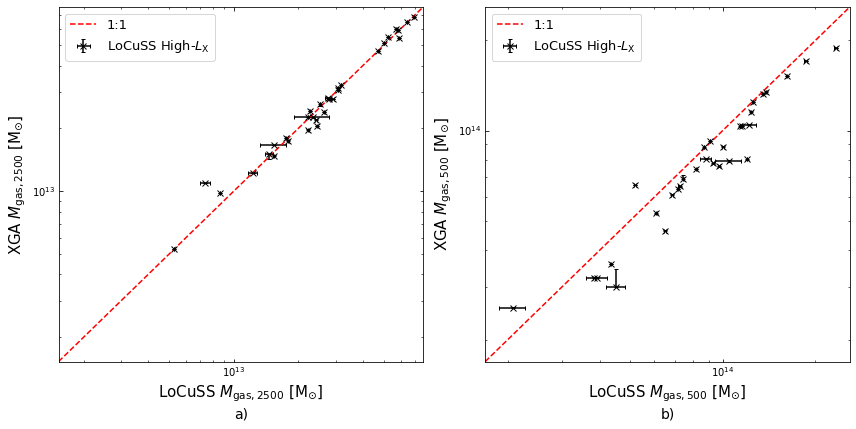

In [27]:
direct_comparison_plot([loc_lit_gm2500s, loc_lit_gms], 
                       [loc_dblbeta_dblking_1r500_gm2500, loc_dblbeta_dblking_1r500_gm500], 
                       [r"LoCuSS $M_{\rm{gas, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{gas, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{gas, 2500}}$ [M$_{\odot}$]", r"XGA $M_{\rm{gas, 500}}$ [M$_{\odot}$]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6), ['log', 'log'], ['log', 'log'], 
                       savepath='../../outputs/figures/locuss_1r500_gmcomp_dblbeta_dblking.pdf')

## Investigating the failed density profile

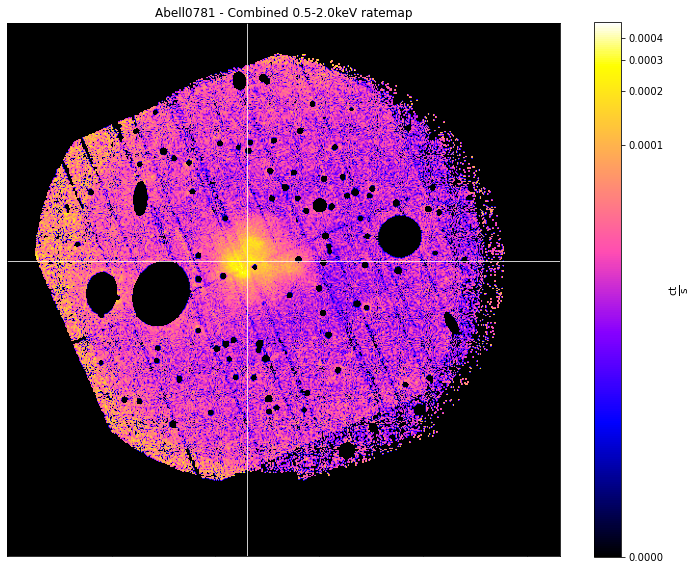

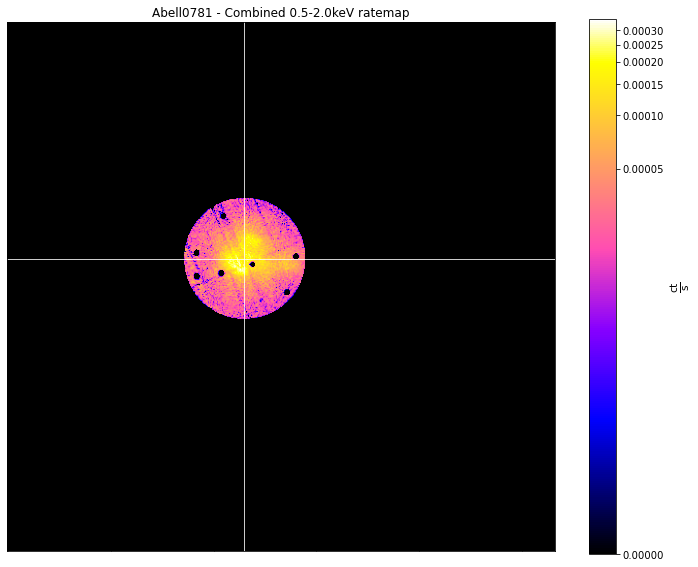

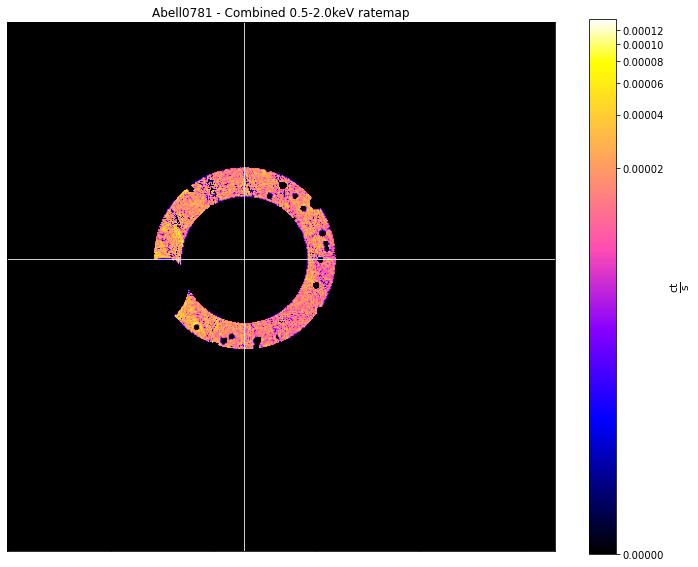


-----------------------------------------------------
Source Name - Abell0781
User Coordinates - (140.103, 30.5031) degrees
nH - 0.0147 1e+22 / cm2
Redshift - 0.298
XMM ObsIDs - 2
PN Observations - 2
MOS1 Observations - 2
MOS2 Observations - 2
On-Axis - 2
With regions - 2
Total regions - 157
Obs with 1 detection - 2
Obs with >1 matches - 0
Total exposure - 146.96 ks
Images associated - 18
Exposure maps associated - 12
Combined Ratemaps associated - 2
Spectra associated - 30
Fitted Models - constant*tbabs*apec | constant*tbabs*apec | constant*tbabs*apec | constant*tbabs*apec
R500 - 1130.0 kpc
R500 SNR - 205.12
R2500 - 310.0 kpc
R2500 SNR - 63.38
-----------------------------------------------------



In [52]:
fail_src = locuss_srcs[loc_dblbeta_1r500_dp.index(None)]
fail_src.get_combined_ratemaps().view(fail_src.ra_dec, fail_src.get_interloper_mask())
fail_src.get_combined_ratemaps().view(fail_src.ra_dec, fail_src.get_mask('r500')[0])
fail_src.get_combined_ratemaps().view(fail_src.ra_dec, fail_src.get_mask('r500')[1])
fail_src.info()

In [67]:
print(locuss_srcs.Tx(locuss_srcs.r500, inner_radius=locuss_srcs.r500*0.15, quality_checks=False))

[[ 6.97588     0.17101359  0.16841352]
 [ 6.8667      0.2335135   0.25178903]
 [ 6.79421     0.17557643  0.1791462 ]
 [ 5.88767     0.12659172  0.1269914 ]
 [ 5.71599     0.12158585  0.15366154]
 [ 3.45714     0.09022618  0.0851814 ]
 [ 7.13786     0.17511194  0.19159227]
 [ 5.90133     0.23266786  0.24602136]
 [ 4.13436     0.12685724  0.12546479]
 [ 4.38927     0.11439112  0.1142571 ]
 [ 6.17218     0.113795    0.11154422]
 [ 6.11918     0.11648216  0.1251118 ]
 [ 6.32049     0.1484371   0.15167014]
 [ 9.58744     0.25523143  0.25824718]
 [ 4.02934     0.15064275  0.15442677]
 [ 5.47196     0.12376395  0.13529962]
 [ 7.32791     0.22088575  0.23456582]
 [ 6.06266     0.13789238  0.15141305]
 [ 3.25839     0.08558675  0.08921422]
 [ 6.64412     0.18180822  0.18293538]
 [ 6.74622     0.16906489  0.18920731]
 [ 6.97554     0.06097314  0.06108922]
 [ 9.43339     0.4158797   0.46793192]
 [ 4.72697     0.11213637  0.11228483]
 [ 8.69781     0.16039837  0.15676947]
 [ 8.39075     0.24110912

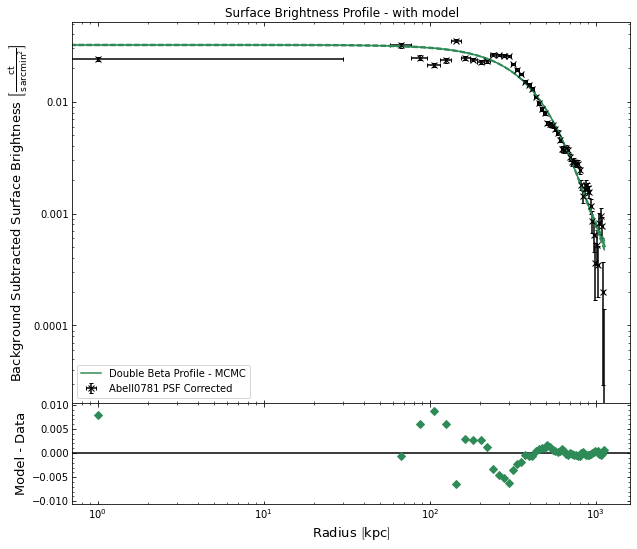

In [56]:
fail_src.get_combined_profiles('brightness').view()

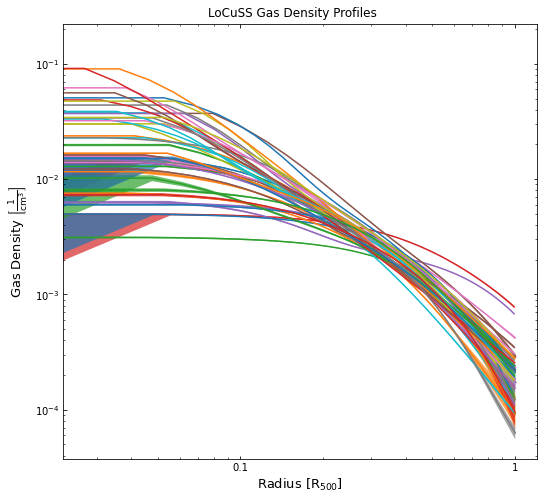

In [80]:
dps = []
for dp in loc_dblbeta_1r500_dp:
    if dp is not None:
        dp.x_norm = locuss_srcs[dp.src_name].r500 / r500_unit
        dps.append(dp)

forms = {'xmajor': FuncFormatter(lambda inp, _: '{:g}'.format(inp))}

BaseAggregateProfile1D(dps).view(axis_formatters=forms, joined_points=True, x_norm=True, show_legend=False, 
                                 custom_title="LoCuSS Gas Density Profiles", figsize=(8.5, 8))

In [31]:
np.nanmean(loc_dblbeta_dblking_1r500_gm2500 / loc_lit_gm2500s)

<Quantity inf>

In [ ]:
np.nanmean((loc_dblbeta_svikh_1r500_gm500 / loc_lit_gms)[:, 0])

In [ ]:
for dp in loc_dblbeta_1r500_dp:
    try:
        dp.generation_profile.view()
    except:
        pass

In [ ]:
loc_dblbeta_1r500_dp_npsf = inv_abel_fitted_model(locuss_srcs, 'double_beta', 'mcmc', locuss_srcs.r500, 
                                                  conv_temp=loc_conv_txs, psf_corr=False)

with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_dblbeta_1r500_dp_npsf)) as onwards:
    for dp in loc_dblbeta_1r500_dp_npsf:
        if dp is not None:
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
        onwards.update(1)

In [ ]:
loc_dblbeta_svikh_1r500_npsf_gm500 = []
loc_dblbeta_svikh_1r500_npsf_gm2500 = []
with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_dblbeta_1r500_dp_npsf)) as onwards:
    for dp in loc_dblbeta_1r500_dp_npsf:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r500)[0]
            loc_dblbeta_svikh_1r500_npsf_gm500.append(gm)
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r2500)[0]
            loc_dblbeta_svikh_1r500_npsf_gm2500.append(gm)
        else:
            loc_dblbeta_svikh_1r500_npsf_gm500.append([np.NaN, np.NaN, np.NaN])
            loc_dblbeta_svikh_1r500_npsf_gm2500.append([np.NaN, np.NaN, np.NaN])
            
        onwards.update(1)        

loc_dblbeta_svikh_1r500_npsf_gm500 = Quantity(loc_dblbeta_svikh_1r500_npsf_gm500, 'Msun')
loc_dblbeta_svikh_1r500_npsf_gm2500 = Quantity(loc_dblbeta_svikh_1r500_npsf_gm2500, 'Msun')

In [ ]:
direct_comparison_plot([loc_lit_gm2500s, loc_lit_gms], [loc_dblbeta_svikh_1r500_npsf_gm2500, 
                                                        loc_dblbeta_svikh_1r500_npsf_gm500], 
                       [r"LoCuSS $M_{\rm{gas, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{gas, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{gas, 2500}}$ [keV]", r"XGA $M_{\rm{gas, 500}}$ [keV]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6), ['log', 'log'], ['log', 'log'])

In [ ]:
loc_dblbeta_1r500_5px_dp = inv_abel_fitted_model(locuss_srcs, 'double_beta', 'mcmc', locuss_srcs.r500, 
                                                  conv_temp=loc_conv_txs, pix_step=5)

with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_dblbeta_1r500_5px_dp)) as onwards:
    for dp in loc_dblbeta_1r500_5px_dp:
        if dp is not None:
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
        onwards.update(1)

In [ ]:
loc_dblbeta_svikh_1r500_5px_gm500 = []
loc_dblbeta_svikh_1r500_5px_gm2500 = []
with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_dblbeta_1r500_5px_dp)) as onwards:
    for dp in loc_dblbeta_1r500_5px_dp:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r500)[0]
            loc_dblbeta_svikh_1r500_5px_gm500.append(gm)
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r2500)[0]
            loc_dblbeta_svikh_1r500_5px_gm2500.append(gm)
        else:
            loc_dblbeta_svikh_1r500_5px_gm500.append([np.NaN, np.NaN, np.NaN])
            loc_dblbeta_svikh_1r500_5px_gm2500.append([np.NaN, np.NaN, np.NaN])
            
        onwards.update(1)        

loc_dblbeta_svikh_1r500_5px_gm500 = Quantity(loc_dblbeta_svikh_1r500_5px_gm500, 'Msun')
loc_dblbeta_svikh_1r500_5px_gm2500 = Quantity(loc_dblbeta_svikh_1r500_5px_gm2500, 'Msun')

In [ ]:
direct_comparison_plot([loc_lit_gm2500s, loc_lit_gms], [loc_dblbeta_svikh_1r500_5px_gm2500, 
                                                        loc_dblbeta_svikh_1r500_5px_gm500], 
                       [r"LoCuSS $M_{\rm{gas, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{gas, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{gas, 2500}}$ [keV]", r"XGA $M_{\rm{gas, 500}}$ [keV]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6), ['log', 'log'], ['log', 'log'])

In [ ]:
for dp in loc_dblbeta_1r500_5px_dp:
    try:
        dp.generation_profile.view(draw_rads={r'$R_{500}$': locuss_srcs[dp.src_name].r500, 
                                              r'$R_{2500}$': locuss_srcs[dp.src_name].r2500}, 
                                   xscale='linear', yscale='linear')
    except:
        pass

## Outputting XGA measured results as a catalogue

We wish to write the gas masses to an easily readable format which can be version controlled:

In [1]:
loc_cols = ['name', 'Mg500', 'Mg500-', 'Mg500+', 'Mg2500', 'Mg2500-', 'Mg2500+']
loc_data = np.hstack([locuss_srcs.names[..., None], loc_beta_king_1r500_gm500.to('1e+14 Msun').value, 
                      loc_beta_king_1r500_gm2500.to('1e+14 Msun').value])
loc_df = pd.DataFrame(loc_data, columns=loc_cols)
loc_df.to_csv('../../outputs/results/locuss_gas_masses.csv', index=False)
loc_df.head(10)

NameError: name 'np' is not defined